In [129]:
import torch
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

In [130]:
n_samples = 1000
X, y = make_circles(n_samples, noise=0.03, random_state=42)

Text(0.5, 1.0, 'Make circles data')

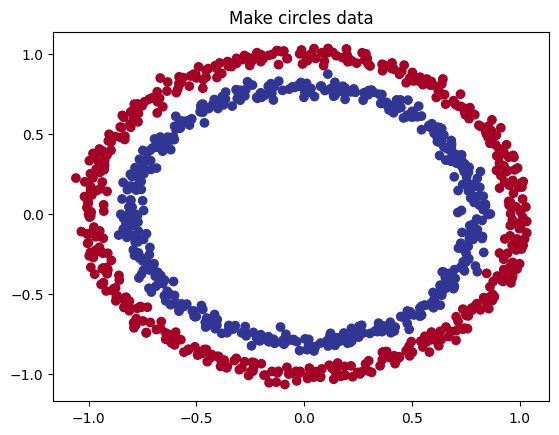

In [180]:
plt.scatter(x=X[:,0], y=X[:,1], c=y, cmap=plt.cm.RdYlBu)
plt.title("Make circles data")


In [132]:
# Convert data to tensors, more specifically into 'float32' datatype as the default datatype in numpy array is float64. This is done as default in torch is float32
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [133]:
type(X), X.dtype, y.dtype

(torch.Tensor, torch.float32, torch.float32)

In [134]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [135]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [136]:
from torch import nn

# using a class to build a clasification network, this is a way to create more complexed neural networks
class CircleClassification(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_1 = nn.Linear(in_features=2, out_features=5)
        self.linear_2 = nn.Linear(in_features=5, out_features=1)

    def forward(self, x:torch.Tensor)-> torch.Tensor:
        return self.linear_2(self.linear_1(x))

In [137]:
model = CircleClassification().to(device)

model.state_dict()

OrderedDict([('linear_1.weight',
              tensor([[-0.5779, -0.4643],
                      [-0.4946,  0.3631],
                      [ 0.0434, -0.5644],
                      [ 0.5871, -0.1663],
                      [-0.3729, -0.1022]], device='cuda:0')),
             ('linear_1.bias',
              tensor([ 0.5109,  0.3789,  0.1703, -0.2410,  0.3423], device='cuda:0')),
             ('linear_2.weight',
              tensor([[-0.1548,  0.3167,  0.2121, -0.1086, -0.4002]], device='cuda:0')),
             ('linear_2.bias', tensor([-0.3199], device='cuda:0'))])

In [138]:
# easier way to create a classification linear neural network

model_1 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
)

model_1.to(device)

model_1.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.4691, -0.6236],
                      [ 0.5023,  0.5779],
                      [ 0.5642, -0.6208],
                      [-0.1237,  0.1755],
                      [-0.4348,  0.3929]], device='cuda:0')),
             ('0.bias',
              tensor([ 0.3494,  0.2045, -0.6533, -0.0994,  0.3449], device='cuda:0')),
             ('1.weight',
              tensor([[-0.3802,  0.4116, -0.3192,  0.3701, -0.1686]], device='cuda:0')),
             ('1.bias', tensor([0.0155], device='cuda:0'))])

In [139]:
# loss functions

# loss_fn = nn.BCELoss() # this is with out the sigmoid layer, you should implement sigmoid by yourself

loss_fn = nn.BCEWithLogitsLoss() # this comes with sigmoid fxn implemented 

optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.01)

In [140]:
# calculate accuracy 

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum()
    acc = (correct / len(y_pred)) * 100
    return acc

In [141]:
epochs = 1000
X_train, X_test, y_train, y_test = X_train.to(device), X_test.to(device), y_train.to(device), y_test.to(device)
# train loop
for epoch in range(epochs):
    model_1.train()
    # logits are direct output of the model
    y_logits = model_1(X_train).squeeze()

    # when logits are passed through an activation function they become final outputs. Turn logits -> pred probs -> pred labels
    y_pred = torch.round(torch.sigmoid(y_logits))

    # loss = loss_fn(torch.sigmoid(y_logits), y_train) # nn.BCELoss expects prediction probabilities as input 

    # nn.BCEWithLogitsLoss expects raw logits as input 
    loss = loss_fn(y_logits, y_train)
    train_acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # set all gradients to zero
    optimizer.zero_grad()
    # backward propagation
    loss.backward()
    # gradient descent 
    optimizer.step()

    model_1.eval()
    with torch.inference_mode():
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_pred, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Train acc: {train_acc:.2f}% | Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%")

    

Epoch: 0 | Loss: 0.71482 | Train acc: 51.12% | Test loss: 0.77781 | Test acc: 47.00%
Epoch: 10 | Loss: 0.71397 | Train acc: 51.25% | Test loss: 0.77471 | Test acc: 47.50%
Epoch: 20 | Loss: 0.71317 | Train acc: 51.00% | Test loss: 0.77471 | Test acc: 47.50%
Epoch: 30 | Loss: 0.71240 | Train acc: 50.87% | Test loss: 0.77471 | Test acc: 47.50%
Epoch: 40 | Loss: 0.71168 | Train acc: 50.75% | Test loss: 0.77661 | Test acc: 47.00%
Epoch: 50 | Loss: 0.71099 | Train acc: 50.75% | Test loss: 0.77661 | Test acc: 47.00%
Epoch: 60 | Loss: 0.71033 | Train acc: 50.75% | Test loss: 0.77661 | Test acc: 47.00%
Epoch: 70 | Loss: 0.70971 | Train acc: 50.75% | Test loss: 0.77661 | Test acc: 47.00%
Epoch: 80 | Loss: 0.70912 | Train acc: 51.00% | Test loss: 0.77661 | Test acc: 47.00%
Epoch: 90 | Loss: 0.70855 | Train acc: 51.25% | Test loss: 0.77661 | Test acc: 47.00%
Epoch: 100 | Loss: 0.70801 | Train acc: 51.38% | Test loss: 0.77661 | Test acc: 47.00%
Epoch: 110 | Loss: 0.70749 | Train acc: 51.38% | Test 

In [142]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


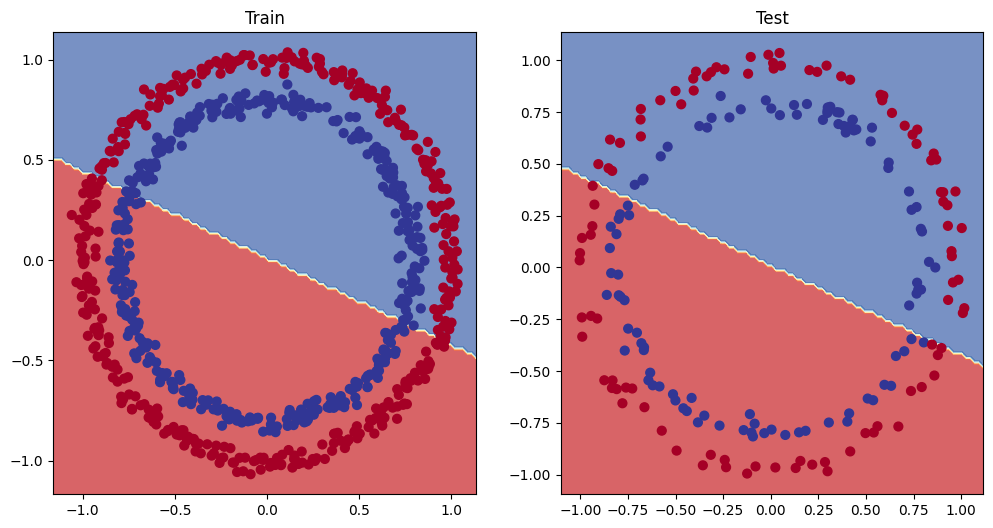

In [143]:
# plot the model outputs
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)

plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)


## Improve the Model to better classify

- We are just focusing on Model improvements and not Data
    - So we can add more hidden layers 
    - We add more hidden units like 128, 256
    - We can add activation fxns for every hidden layer 
    - We are basiaclly increasing the parameters of the model so it has more numbers to adjust 
    - We can change the lr
    - We can change the optimizer and loss function 
    - Increase epochs

In [176]:
class CircleClassification_v2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=128)
        self.layer_2 = nn.Linear(in_features=128, out_features=256)
        self.layer_3 = nn.Linear(in_features=256, out_features=128)
        self.layer_4 = nn.Linear(in_features=128, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x:torch.Tensor)->torch.Tensor:
        return self.layer_4(self.relu(self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))))

model_2 = CircleClassification_v2()

# easier way to build the model
# model_2 = nn.Sequential(
#     nn.Linear(in_features=2, out_features=128),
#     nn.ReLU(),
#     nn.Linear(in_features=128, out_features=256),
#     nn.ReLU(),
#     nn.Linear(in_features=256, out_features=128),
#     nn.ReLU(),
#     nn.Linear(in_features=128, out_features=1)
# )
model_2.to(device)

CircleClassification_v2(
  (layer_1): Linear(in_features=2, out_features=128, bias=True)
  (layer_2): Linear(in_features=128, out_features=256, bias=True)
  (layer_3): Linear(in_features=256, out_features=128, bias=True)
  (layer_4): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

In [177]:
loss_fn = nn.BCEWithLogitsLoss() # this comes with sigmoid fxn implemented 

optimizer = torch.optim.Adam(params=model_2.parameters(), lr=0.0001)

In [178]:
epochs = 200
X_train, X_test, y_train, y_test = X_train.to(device), X_test.to(device), y_train.to(device), y_test.to(device)

# train loop
for epoch in range(epochs):
    model_2.train()
    # logits are direct output of the model
    y_logits = model_2(X_train).squeeze()

    # when logits are passed through an activation function they become final outputs. Turn logits -> pred probs -> pred labels
    y_pred = torch.round(torch.sigmoid(y_logits))

    # loss = loss_fn(torch.sigmoid(y_logits), y_train) # nn.BCELoss expects prediction probabilities as input 

    # nn.BCEWithLogitsLoss expects raw logits as input 
    loss = loss_fn(y_logits, y_train)
    train_acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # set all gradients to zero
    optimizer.zero_grad()
    # backward propagation
    loss.backward()
    # gradient descent 
    optimizer.step()

    model_2.eval()
    with torch.inference_mode():
        test_logits = model_2(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_pred, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Train acc: {train_acc:.2f}% | Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.69232 | Train acc: 51.00% | Test loss: 0.73429 | Test acc: 51.50%
Epoch: 10 | Loss: 0.68854 | Train acc: 50.00% | Test loss: 0.69315 | Test acc: 50.00%
Epoch: 20 | Loss: 0.68532 | Train acc: 50.12% | Test loss: 0.69315 | Test acc: 50.00%
Epoch: 30 | Loss: 0.68161 | Train acc: 54.88% | Test loss: 0.67985 | Test acc: 53.50%
Epoch: 40 | Loss: 0.67733 | Train acc: 59.88% | Test loss: 0.66845 | Test acc: 56.50%
Epoch: 50 | Loss: 0.67178 | Train acc: 63.50% | Test loss: 0.65516 | Test acc: 60.00%
Epoch: 60 | Loss: 0.66463 | Train acc: 68.25% | Test loss: 0.62667 | Test acc: 67.50%
Epoch: 70 | Loss: 0.65574 | Train acc: 73.62% | Test loss: 0.60387 | Test acc: 73.50%
Epoch: 80 | Loss: 0.64447 | Train acc: 79.50% | Test loss: 0.58298 | Test acc: 79.00%
Epoch: 90 | Loss: 0.63068 | Train acc: 87.75% | Test loss: 0.55259 | Test acc: 87.00%
Epoch: 100 | Loss: 0.61375 | Train acc: 93.62% | Test loss: 0.52980 | Test acc: 93.00%
Epoch: 110 | Loss: 0.59304 | Train acc: 97.00% | Test 

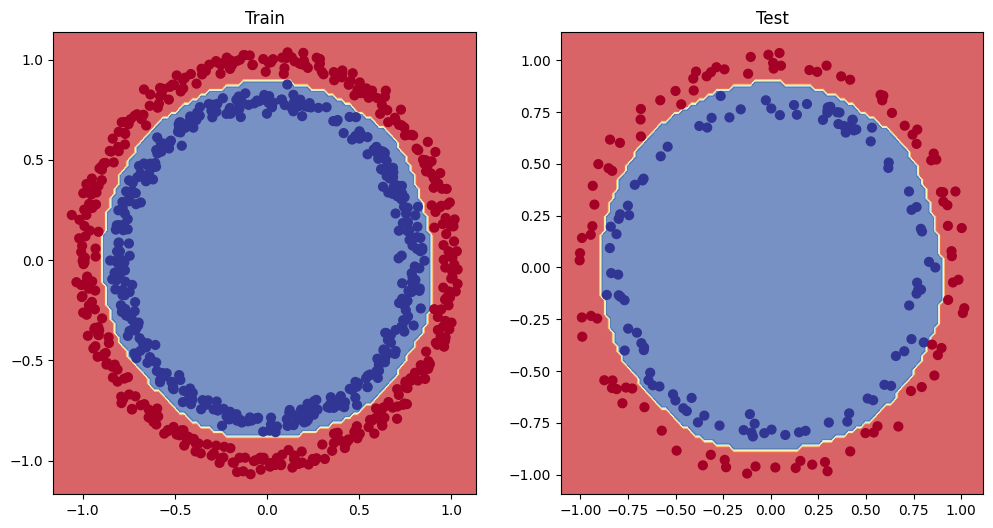

In [179]:
# plot the model outputs
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_2, X_train, y_train)

plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_2, X_test, y_test)


In [153]:
X_train

tensor([[ 0.6579, -0.4651],
        [ 0.6319, -0.7347],
        [-1.0086, -0.1240],
        ...,
        [ 0.0157, -1.0300],
        [ 1.0110,  0.1680],
        [ 0.5578, -0.5709]], device='cuda:0')